# Learning Rate Range Test
### Reference
1. [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186)

The most important hyperparameter is learning rate, however it's cumbersome work for finding just the right learning rate. Every model, problem, and dataset requires different learning rate. Some researchers initiate ramdom high learning rate, then decay it under certian conditions for example every N epochs or loss / accuracy doesn't get imporved etc.

This test is originally used for finding learning rate range.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import backend

In [ ]:
class ResBlock(models.Model):
  def __init__(self, filters, layer):
    super().__init__()
    f1, f2, f3 = filters
    self.layer = layer
    self.BN1 = layers.BatchNormalization()
    self.swish1 = layers.Activation(activation=tf.nn.swish)
    self.conv1 = layers.Conv2D(filters=f1, kernel_size=(1, 1), strides=(1, 1), padding='same')
    self.BN2 = layers.BatchNormalization()
    self.swish2 = layers.Activation(activation=tf.nn.swish)
    self.conv2 = layers.Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1) if self.layer > 0 else (2, 2), padding='same')
    self.BN3 = layers.BatchNormalization()
    self.swish3 = layers.Activation(activation=tf.nn.swish)
    self.conv3 = layers.Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1), padding='same')
    self.id = layers.Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1) if self.layer > 0 else (2, 2), padding='same')
    self.add = layers.Add()

  def call(self, X):
    x = self.BN1(X)
    x = self.swish1(x)
    x = self.conv1(x)
    x = self.BN2(x)
    x = self.swish2(x)
    x = self.conv2(x)
    x = self.BN3(x)
    x = self.swish3(x)
    x = self.conv3(x)
    if self.layer == 0:
      id = self.id(X)
      return self.add([x, id])
    return self.add([x, X])

In [ ]:
block_args = [
              {'filters': [8, 8, 32], 'repeat': 2},
              {'filters': [16, 16, 64], 'repeat': 3},
              ]

In [ ]:
class Config:
  epochs = 3
  batch_size = 256
  lr = 0.001
  min_lr = 0.001
  max_lr = 0.1
  # loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  # metrics = keras.metrics.Accuracy()
  loss = 'sparse_categorical_crossentropy'
  metrics = 'accuracy'

In [ ]:
def model(args):
  inputs = layers.Input(shape=(32, 32, 3))
  x = layers.Conv2D(filters=4, kernel_size=(1, 1), strides=(1, 1), padding='same')(inputs)
  
  for stage, arg in enumerate(args):
    for layer in range(arg['repeat']):
      x = ResBlock(arg['filters'], layer)(x)
      print(f'Stage: {stage+2}-{layer+1}, shape: {x.shape}')
  x = layers.AveragePooling2D(pool_size=(8, 8))(x)
  x = layers.Flatten()(x)
  x = layers.Dense(units=10, activation='softmax')(x)
  print(x)
  out = models.Model(inputs=inputs, outputs=x)
  out.compile(optimizer=optimizers.SGD(learning_rate=Config.lr, momentum=0.9), loss=Config.loss, metrics=Config.metrics)
  return out

In [ ]:
class Preproseccing:  
  def normalize(self, X):
    return X / 255.

  def zero_centered(self, X):
    return X - 0.5

  def __call__(self, X):
    x = self.normalize(X)
    x = self.zero_centered(x)
    return x

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
train_data = Preproseccing()(x_train)
test_data = Preproseccing()(x_test)

In [ ]:
class LRrangeTest(callbacks.Callback):
  def __init__(self, min_lr=1e-9, max_lr=1e+1, policy: str='linear'):
    self.min_lr = min_lr
    self.max_lr = max_lr
    self.policy = policy
    self.epochs = None
    self.steps = None
    self.num_iter = None
    self.iter_counter = 0
    self.learning_rates = None
    self.losses = []
    self.lowest_loss = None

  def on_train_begin(self, logs=None):
    self.epochs = self.params.get('epochs')
    self.steps = self.params.get('steps')
    self.num_iter = self.epochs * self.steps
    if self.policy == 'linear':
      self.learning_rates = np.linspace(start=self.min_lr, stop=self.max_lr, num=self.num_iter+1)
    elif self.policy == 'exponential':
      self.learning_rates = np.geomspace(start=self.min_lr, stop=self.max_lr, num=self.num_iter+1)
    print('Learning rates are initiated')
    if self.min_lr:
      backend.set_value(self.model.optimizer.learning_rate, self.min_lr)
    else:
      backend.set_value(self.model.optimizer.learning_rate, self.learning_rates[self.iter_counter])
   

  def on_batch_end(self, batch, logs=None):
    lr = backend.get_value(self.model.optimizer.learning_rate)
    logs['lr'] = lr

    loss = logs.get('loss')
    if self.iter_counter == 0 or loss < self.lowest_loss:
      self.lowest_loss = loss
      logs['best_loss'] = self.lowest_loss
    
    if loss > self.lowest_loss * 2:
      self.model.stop_training = True
    self.losses.append(loss)
    self.iter_counter += 1
    next_lr = self.learning_rates[self.iter_counter]
    # print(f' - next_lr: {next_lr}')
    backend.set_value(self.model.optimizer.learning_rate, next_lr)
  
  def on_train_end(self, logs=None):
    plt.figure(figsize=(12, 6))
    plt.plot(self.learning_rates[:len(self.losses)], self.losses)
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss")
    plt.xscale('log')
    plt.show()

In [ ]:
m = model(block_args)

Stage: 2-1, shape: (None, 16, 16, 32)
Stage: 2-2, shape: (None, 16, 16, 32)
Stage: 3-1, shape: (None, 8, 8, 64)
Stage: 3-2, shape: (None, 8, 8, 64)
Stage: 3-3, shape: (None, 8, 8, 64)
KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), name='dense_7/Softmax:0', description="created by layer 'dense_7'")


Learning rates are initiated
Epoch 1/3
157/157 [==============================] - 92s 573ms/step - loss: 1.7947 - accuracy: 0.3270 - lr: 0.1664 - best_loss: 1.9758 - val_loss: 4.8736 - val_accuracy: 0.2340
Epoch 2/3
157/157 [==============================] - 87s 556ms/step - loss: 1.5309 - accuracy: 0.4369 - lr: 0.4994 - best_loss: 1.5367 - val_loss: 22.6606 - val_accuracy: 0.1060
Epoch 3/3
157/157 [==============================] - 16s 100ms/step - loss: 3.0819 - accuracy: 0.3451 - lr: 0.6882 - val_loss: 672.8099 - val_accuracy: 0.1016


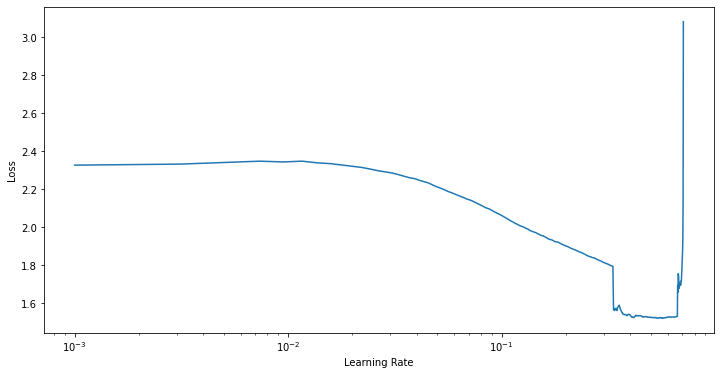

In [ ]:
linear_lr = m.fit(x=train_data, y=y_train, batch_size=Config.batch_size, epochs=Config.epochs,
                  validation_split=0.2, callbacks=[LRrangeTest(min_lr=1e-3, max_lr=1, policy='linear')])

In [ ]:
m2 = model(block_args)

Stage: 2-1, shape: (None, 16, 16, 32)
Stage: 2-2, shape: (None, 16, 16, 32)
Stage: 3-1, shape: (None, 8, 8, 64)
Stage: 3-2, shape: (None, 8, 8, 64)
Stage: 3-3, shape: (None, 8, 8, 64)
KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), name='dense_13/Softmax:0', description="created by layer 'dense_13'")


Learning rates are initiated
Epoch 1/3
157/157 [==============================] - 106s 662ms/step - loss: 2.0931 - accuracy: 0.2242 - lr: 0.0039 - best_loss: 2.2400 - val_loss: 2.4020 - val_accuracy: 0.1078
Epoch 2/3
157/157 [==============================] - 96s 612ms/step - loss: 1.7289 - accuracy: 0.3568 - lr: 0.0388 - best_loss: 1.7799 - val_loss: 2.7763 - val_accuracy: 0.2827
Epoch 3/3
157/157 [==============================] - 96s 612ms/step - loss: 1.6152 - accuracy: 0.4051 - lr: 0.3880 - best_loss: 1.5834 - val_loss: 29.7101 - val_accuracy: 0.0867


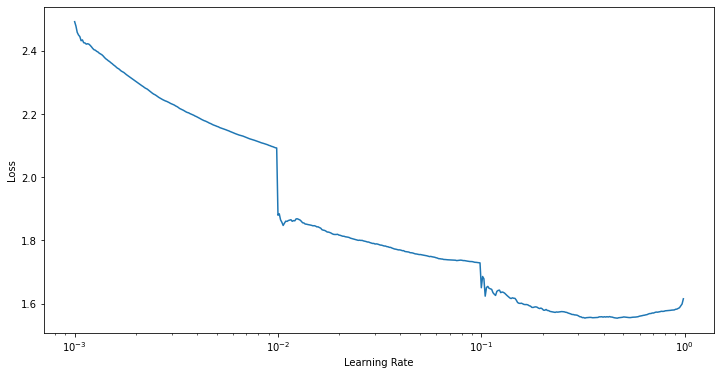

In [ ]:
exponential_lr = m2.fit(x=train_data, y=y_train, batch_size=Config.batch_size, epochs=Config.epochs, 
                        validation_split=0.2, callbacks=[LRrangeTest(min_lr=1e-3, max_lr=1, policy='exponential')])

Text(0.5, 1.0, 'LR policy')

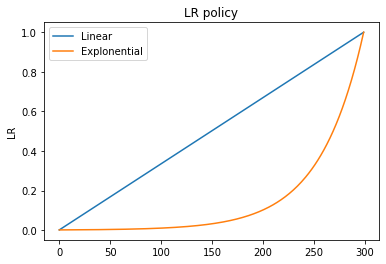

In [51]:
plt.plot(np.linspace(start=1e-3, stop=1, num=300), label='Linear')
plt.plot(np.geomspace(start=1e-3, stop=1, num=300), label='Explonential')
plt.legend()
plt.ylabel('LR')
plt.title('LR policy')

## Further study:
1. Fix seeds every weight. Every test results wasn't consistent.
2. Cyclical Learning Rate